In [27]:
import pandas as pd
import torch
from transformers import EsmModel, EsmTokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap  # Correct import for UMAP
from sklearn.manifold import TSNE
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

features = ['interface_score', 'total_score', 'efield_score','generation']
invert   = ['interface_score', 'total_score']

# Define the dataset path and output folder
dataset = './data/240705_all_scores_resi99.csv'
output_folder = '../../AIzymes_resi99'
esm2_model = "facebook/esm2_t6_8M_UR50D"
# esm2_model = "facebook/esm2_t33_650M_UR50D"
# esm2_model = "facebook/esm2_t36_3B_UR50D"
# esm2_model = "facebook/esm2_t48_15B_UR50D"

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read the dataset
df = pd.read_csv(dataset)
df = df#[9000:]
df = df[df['sequence'].notnull()]
print(f'### Analyzing {len(df)} datapoints. ###')

for feature in features:
    if feature not in invert: continue
    df[feature] = -df[feature]

sequences = list(dict.fromkeys(df['sequence']))
print(f'### Dataset contains {len(sequences)} unique seuqences. ###')

# Tokenize dataset
tokenizer = EsmTokenizer.from_pretrained(esm2_model)
tokenized_sequence = [tokenizer(sequence, return_tensors='pt') for sequence in sequences]

# ESM embedding
model = EsmModel.from_pretrained(esm2_model).to(device)
model.eval()
def get_last_hidden_states(model, tokenized_sequences):
    with torch.no_grad():
        all_hidden_states = []
        for seq in tokenized_sequences:
            seq = {k: v.to(device) for k, v in seq.items()}
            output = model(**seq)
            hidden_states = output.last_hidden_state.squeeze(0).mean(dim=0).cpu().numpy()
            all_hidden_states.append(hidden_states)
        return np.array(all_hidden_states)
all_hidden_states = get_last_hidden_states(model, tokenized_sequence)
print("### Embedding done ###")

# Dimensionality reduction
umap_model = umap.UMAP()  
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)

umap_df = pd.DataFrame(umap_model.fit_transform(all_hidden_states), columns=['umap_x', 'umap_y'], index=sequences)
tsne_df = pd.DataFrame(tsne.fit_transform(all_hidden_states), columns=['tsne_x', 'tsne_y'], index=sequences)
pca_df = pd.DataFrame(pca.fit_transform(all_hidden_states), columns=['pca_x', 'pca_y'], index=sequences)

umap_df['sequence'] = sequences
tsne_df['sequence'] = sequences
pca_df['sequence'] = sequences

# Merge these dataframes back with the original dataframe
df = pd.merge(df, umap_df, on='sequence', how='left')
df = pd.merge(df, tsne_df, on='sequence', how='left')
df = pd.merge(df, pca_df, on='sequence', how='left')

### Analyzing 9999 datapoints. ###
### Dataset contains 4650 unique seuqences. ###


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Embedding done ###


,index,sequence,parent_index,interface_score,total_score,catalytic_score,efield_score,interface_potential,total_potential,catalytic_potential,...,cat_resi,cat_resn,kbt_boltzmann,luca,umap_x,umap_y,tsne_x,tsne_y,pca_x,pca_y
0,0.0,MNTPEHITAVIQRFVAALNAGDLDGLVALFADDATVEVPVGSEPRS...,Parent,21.165,385.054,2.118,67.536784,-22.24200,-396.818333,1.735333,...,99.0,GLU,0.500000,1ohp,18.442051,10.446733,34.367146,59.379330,0.757434,0.728644
1,1.0,MNTPEHITAVVQRYIAALNAGDLDGIVALFADDATVEIPVGSEPRS...,Parent,18.273,228.305,149.491,33.690663,-18.27300,-228.305000,149.491000,...,99.0,GLU,0.499655,1ohp,19.286041,9.593630,21.428326,54.291653,0.513788,0.677974
2,2.0,MNTPEHITAVVQRWVAALNAGDLDGVVALFADDATVEVPVGSEPRS...,Parent,22.968,262.631,70.641,47.824996,-22.96800,-262.631000,70.641000,...,99.0,GLU,0.499310,1ohp,19.348249,10.520527,27.154713,52.209488,0.752894,0.588428
3,3.0,MNTPEHITAVIQRLVAAMNAGDLDGIVALFADDATVEVPVGSEPRS...,Parent,14.542,323.962,1.714,82.169753,-14.54200,-323.962000,1.714000,...,99.0,GLU,0.498965,1ohp,19.360155,9.832936,23.037560,54.470249,0.560217,0.624898
4,4.0,MNTPEHMTAVVQRFMAALNAGDLDGLVALFADDATVEVPVGSEPRS...,Parent,19.880,383.686,2.366,104.159109,-20.29725,-394.036250,1.934750,...,99.0,GLU,0.498620,1ohp,19.754066,10.320812,22.557526,46.996326,0.692189,0.587408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9996.0,MLTEEELTALVERYLAALNAKDLDGLVAMFAPDAVLEIPVGSEPRV...,9463,30.896,464.435,2.234,183.233537,-30.89600,-464.435000,2.234000,...,99.0,ASP,0.000501,1ohp,-6.027317,7.857376,-31.834370,4.792144,-0.401977,0.004591
9995,9997.0,MLTEEELTALVERYLAALNAKDLDGLVAMFAPDAVLEIPVGSEPKV...,9724,30.349,457.878,2.408,200.196544,-30.34900,-457.878000,2.408000,...,99.0,ASP,0.000501,1ohp,-6.843421,8.072844,-44.222717,4.477671,-0.550819,-0.134672
9996,9998.0,MLTEEELTALVERYLALLNAKDLDGLVAMFAPDAVLEIPVGSEPKV...,9024,30.723,463.722,1.966,186.786279,-30.72300,-463.722000,1.966000,...,99.0,ASP,0.000501,1ohp,-5.959085,8.823449,-35.483269,14.046467,-0.527459,0.042351
9997,9999.0,MLTEEELTALVERYLALLNAKDLDGLVAMFAPDAVLEIPVGSEPKV...,8393,26.633,465.193,1.394,196.516444,-26.63300,-465.193000,1.394000,...,99.0,ASP,0.000500,1ohp,-5.910013,8.815877,-35.614693,15.094559,-0.527039,0.059509


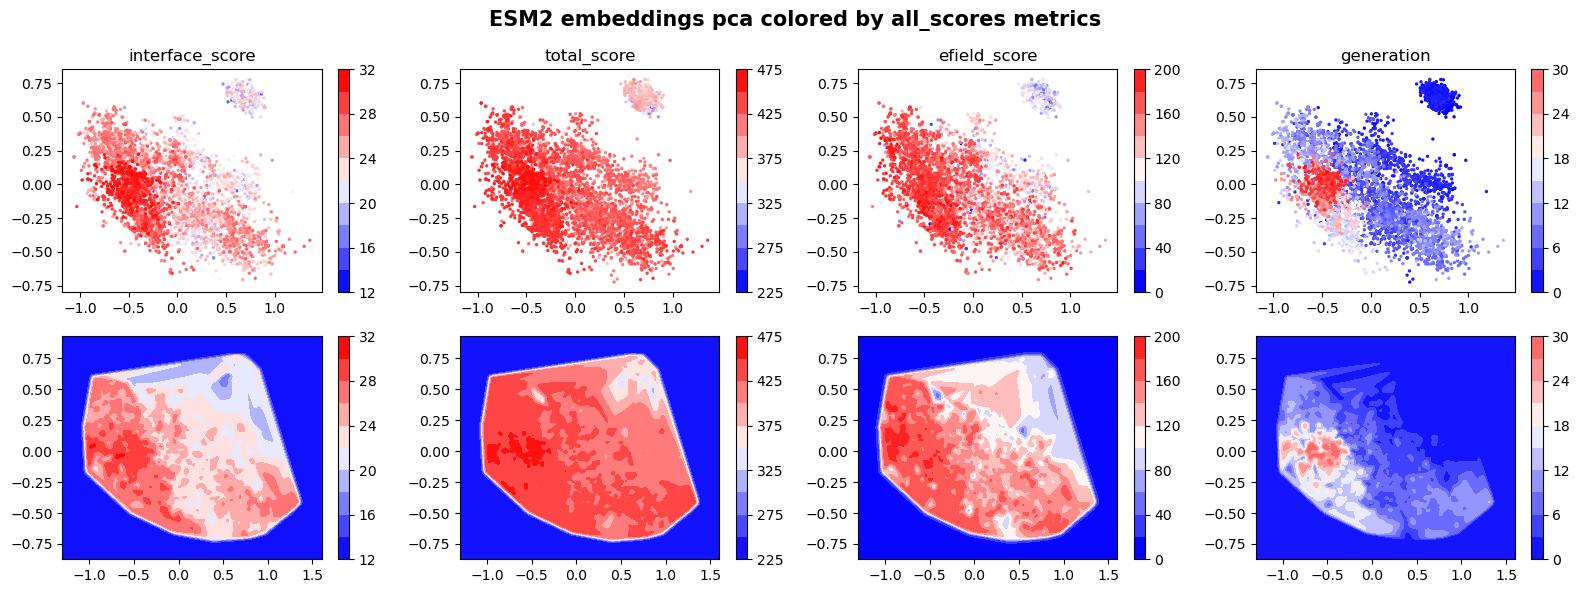

In [28]:
from scipy.spatial.distance import cdist

# Define the distance threshold

# Plotting
for dim in ['pca', 'umap', 'tsne']:

    if dim == 'pca':   distance_threshold = 10 
    if dim == 'umap':  distance_threshold = 0.5  
    if dim == 'tsne':  distance_threshold = 1.0 

    fig, axs = plt.subplots(2, 4, figsize=(16, 6))
    fig.suptitle(f'ESM2 embeddings {dim} colored by all_scores metrics', fontsize=15, weight='bold')

    for idx, feature in enumerate(features):

        # Get the data
        x = df[f'{dim}_x']
        y = df[f'{dim}_y']
        z = df[feature]
        vmin, vmax = z.min(), z.max()
        
        # Scatter plot
        scatter = axs[0, idx].scatter(x, y, c=z, cmap='bwr', s=2, vmin=vmin, vmax=vmax, zorder=10)
        axs[0, idx].set_title(feature)

        # Extend limits by 10%
        x_margin = (x.max() - x.min()) * 0.1
        y_margin = (y.max() - y.min()) * 0.1
        x_min, x_max = x.min() - x_margin, x.max() + x_margin
        y_min, y_max = y.min() - y_margin, y.max() + y_margin

        # Create grid for interpolation
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
        zz = griddata((x, y), z, (xx, yy), method='linear')

        # Compute distances to the nearest data point
        grid_points = np.column_stack([xx.ravel(), yy.ravel()])
        data_points = np.column_stack([x, y])
        distances = cdist(grid_points, data_points, metric='euclidean').min(axis=1)
        distance_mask = distances.reshape(xx.shape) > distance_threshold
        zz[distance_mask] = np.nan

        # Replace remaining NaNs with the mean of zz and apply Gaussian filter
        zz[np.isnan(zz)] = np.nanmin(zz)
        zz = gaussian_filter(zz, sigma=3)

        # Plot filled contour with masked array
        contour = axs[1, idx].contourf(xx, yy, zz, levels=10, cmap='bwr', zorder=1, vmin=vmin, vmax=vmax)

        # Add colorbar
        fig.colorbar(contour, ax=axs[0, idx], orientation='vertical')
        fig.colorbar(contour, ax=axs[1, idx], orientation='vertical')

    plt.tight_layout()
    fig.savefig(f'{output_folder}/esm2_embeddings_{dim}.png')
    plt.show()